In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import re

## VIVADATA PROJECT

Ce repo retrace mon projet final dans le cadre du batch 10 du bootcamp Data science de VIVADATA. Ce projet exploite la base de données CAPP fournie par la Direction de l'Information Légale et Administratives (DILA) placée sous l'autorité du Premier ministre et rattachée au secrétaire général du gouvernement.

### La base de données

La base de données est disponible sur [ici](https://www.data.gouv.fr/fr/datasets/capp/#_). Il s'agit d'un fonds documentaire de jurisprudence des cours d’appel et des juridictions de premier degré est composé d’une sélection de décisions en matière civile et pénale.

Les données sont téléchargeable [ici](https://echanges.dila.gouv.fr/OPENDATA/CAPP/). La base de donnée est mise à jour plusieurs fois par mois.

### Le projet

Le projet est de mettre en place une application permettant pour une requête données de fournir les décisions les plus pertinentes.

__To Do list__ 
- [ ] Github
- [x] Récuperer les données
- [x] Data cleaning
- [ ] EDA
    - [ ] Data visualisation
    - [ ] Text exploratory
    - [ ] Topic modeling
- [ ] Text similarity
    - [ ] Find a measure of similarity
    - [ ] Find a measure of performance
    - [ ] Tf-IDF 
        - [ ] 1-gram
        - [ ] n-gram
        - [ ] Topic modeling cluster
    - [ ] Word embedding
       - [ ] Spacy
       - [ ] Word2vec
       - [ ] Doc2vec
       - [ ] (Google Cloud instance ?)
- [ ] Deployement 
    - Save model
    - Develop app
    - Test unitaires
    - Online publishing
- [ ] Bonus :
    - [ ] Mise à jour automatique (mensuellement) des données
    - [ ] Selection par l'utilisation de la date, la nature, ou la possibilité de cherche un décision spécifique
-------
### Récuparation des données

#### `CAPP_retrivial.py`

La base de donnée est composée de fichiers gunzip contenant chacun une arboresence de dossiers où se trouve des les décisions de justice sous format XML. Ce script permet de python CAPP comprend deux fonctions permettant à partir des fichiers gunzip téléchargés de récupérer l'ensemble des fichiers XML distincts et de les stockers dans un dossier unique facilitant leur utilisation. 

`CAPP_retrievial(path_in: str, path_out: str)`<br>
Permet de récupérer les décisions des fichiers gunzip périodiques. Alexis Eidelman fournis sur son Gitub un script python pour télécharger de manière automatique tous ces fichiers et les décompresser ([TarDilaData](https://github.com/AlexisEidelman/TarDilaData)). 

`CAPP_freemium_retrievial(path_in: str, path_out: str)`<br>
Permet de récupérer les décisions du fichier Freemium_capp_global_20180315-170000.tar.gz. Ce fichier est bien plus lourd puisqu'il contient les décisions postérieures à mars 2018. Il doit être télécharger et décompresser à la main.

#### `xml_to_sql.py`

Ce script contient une fonction `data(path_in: str, path_out: str)` permettant de scrapper les données suivantes des décisions : 
* l'identifiant de la décision `ID`
* le numéro `NUMERO_AFFAIRE`
* la date `DATE_DEC`
* la nature de la décision `NATURE`
* la juridiction `SIEGE_APPEL`
* les labels `SCT`
* la décision `CONTENU`

Ces données sont stockées dans une table Data d'une base de donnée SQL qu'il faut définir. 

------------
### Nettoyage des données

Les données ont été téléchargées le 04/05/2020, la base de donnée à ce jour contient 67210 décisions. Le nettoyage des données à consiste à remplacer les valeurs 'null' en NaN, transformer les dates en format datetime. Afin de faciliter le traitement de la base de donnée, les modifications de celles-ci sont stockers dans un DataFrame Pandas contenu dans un fichier pickle. 

------------
### EDA

In [2]:
df = pd.read_pickle('data.pkl')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67210 entries, 0 to 67209
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID              67210 non-null  object        
 1   NUMERO_AFFAIRE  59061 non-null  object        
 2   DATE_DEC        67210 non-null  datetime64[ns]
 3   NATURE          57570 non-null  object        
 4   SIEGE_APPEL     64240 non-null  object        
 5   CONTENU         67210 non-null  object        
 6   SCT             17098 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 3.6+ MB


### Données dupliquées

Le jeu de donnée ne contient pas de décision en double.

In [6]:
df['ID'].duplicated().sum()

0

## Visualisation des données

### Répartition temporelle
Les décisions ne sont pas réparties de manière homogènes dans le temps. 25,3 % des décisions ont été rendues entre 2007 et 2008.

In [7]:
df['DATE_DEC'].dt.year[(df['DATE_DEC'].dt.year == 2008) | (df['DATE_DEC'].dt.year == 2007)].count()/len(df)

0.25342954917423005

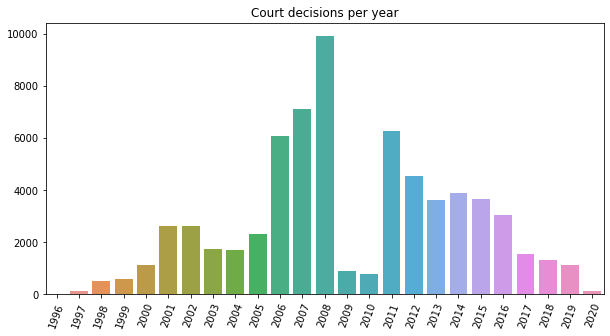

In [8]:
plt.figure(figsize = (10, 5))
sns.barplot(x = df.groupby(df['DATE_DEC'].dt.year).count().index,
            y = df.groupby(df['DATE_DEC'].dt.year).count()['ID'].values)
plt.xlabel(None)
plt.title('Court decisions per year')
plt.xticks(rotation =70)
plt.show()

### Nature des décisions

79,4 % des décisions sont des arrêts. Ainsi si la base de données contient des décisions émanant d'autres juridictions, il s'agit de pour un grande majorité de décision de cours d'appel. 

In [9]:
df['ID'][df['NATURE'] == 'ARRET'].count()/len(df)

0.7945543817884243

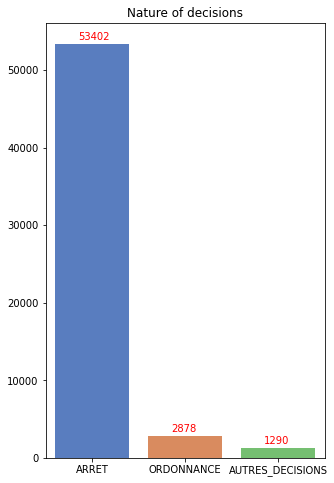

In [10]:
plt.figure(figsize = (5,8))
ax = sns.countplot(df['NATURE'], palette = 'muted')
for i, v in df['NATURE'].value_counts().reset_index().iterrows():
    ax.text(i - 0.15, v[1] + 500 , v[1], color='red')
plt.ylabel(None)
plt.xlabel(None)
plt.title('Nature of decisions')
plt.show()

### Repartition géographique

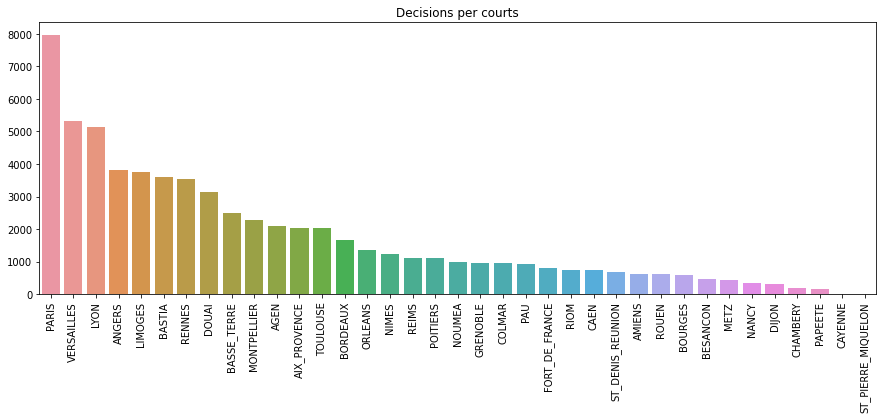

In [11]:
plt.figure(figsize = (15,5))
sns.countplot(df['SIEGE_APPEL'], order = df['SIEGE_APPEL'].value_counts().index)
plt.xticks(rotation = 90)
plt.ylabel(None)
plt.xlabel(None)
plt.title('Decisions per courts')
plt.show()

### Labels

Seules 25,4 % des décisions ont un label.

In [12]:
df['SCT'].notnull().sum()/len(df)

0.2543966671626246

In [16]:
def SCT_cleaning(x):
    x = re.sub(r"(\w)([A-Z][a-z])", r"\1 \2", x)
    x = x.split('\n\n')
    x = [i.split(' - ') for i in x]
    x = [i.strip().lower() for i in itertools.chain.from_iterable(x) if i != '']
    x = [re.sub('null*', '', i).strip() for i in x]
    x = [re.sub('\n*', '', i).strip() for i in x]
    x = [re.sub('jdf*', '', i).strip() for i in x]
    x = ' '.join(x)
    return x

In [17]:
df['labels'] = df.SCT[df.SCT.notnull()].apply(SCT_cleaning)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load("fr_core_news_md")

In [17]:
def preprocess_spacy(sent):
    doc = nlp(sent)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

In [20]:
df['label_tokens'] = df.labels[df.labels.notnull()].apply(preprocess_spacy)

In [48]:
vectorizer = CountVectorizer(lowercase = False, analyzer = lambda x: x)

In [22]:
BOW = vectorizer.fit_transform(df.label_tokens[df.label_tokens.notnull()]).toarray()

In [23]:
bow = pd.DataFrame(data=BOW, columns=vectorizer.get_feature_names())

In [24]:
bow.sum(axis = 0).sort_values().tail(15)

loi               1075
bail              1140
licenciement      1189
obligation        1190
action            1219
responsabilité    1301
judiciaire        1314
rupture           1441
difficulte        1483
application       1556
civil             1670
entreprise        1758
condition         2026
travail           3698
contrat           3873
dtype: int64

Cette première analyse des labels met en avant quelque chose de très intérressant. Les concepts juridiques étant généralement composé de plusieurs mots, comme 'entreprise en difficulté' ou 'contrat de travail', il semble plus pertinent de travailer avec n-gram (bi-gram ou tri-gram). 

In [84]:
df['tokens_join'] = df.label_tokens[df.label_tokens.notnull()].apply(lambda x: ' '.join(x))

In [95]:
vec = CountVectorizer(lowercase = False, ngram_range=(2, 2))
BOW_grams = vec.fit_transform(df.tokens_join[df.tokens_join.notnull()]).toarray()

In [96]:
bow_gram = pd.DataFrame(data=BOW_grams, columns=vec.get_feature_names())

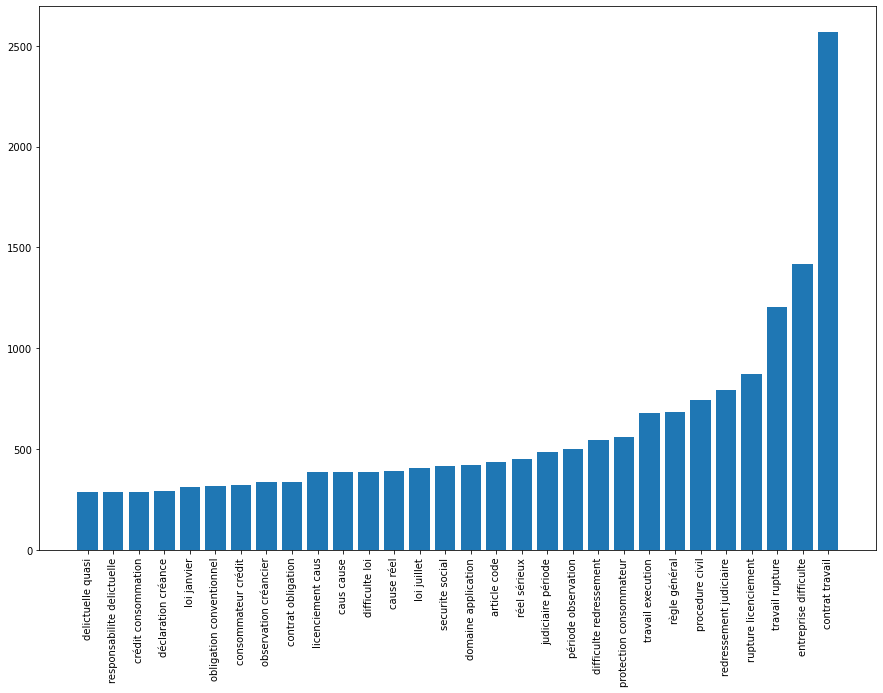

In [130]:
plt.figure(figsize = (15, 10))
plt.bar(bow_gram.sum(axis = 0).sort_values().tail(30).index,
        height = bow_gram.sum(axis = 0).sort_values().tail(30).values)
plt.xticks(rotation = 90)
plt.show()

Nous pourrions utiliser ces labels pour entrainer une modèle de classification afin d'étiqueter le reste de notre base. Toutefois cela ne serait pas pertinent au regard de notre objectif puisque ne nous cherchons pas à faire matcher une requête utilisateur avec un label mais avec un texte dans son ensemble. 

Cependant, l'analyse de ces labels permet d'avoir un bon aperçu de la répartition des thématiques juridiques dans notre base de données. Nous pouvons constater que les thèmes principaux sont le droit du travail et en particulier la rupture du contrat de travail, ainsi que les procédures collectives et enfin la procédure civile.

### Textes

On peut d'ores et déjà identifer des mots qui n'apporte pas d'information utile comme 'greffier', 'condamne', 'par ces motifs'. De plus, les numéros restent utiles lorsqu'ils sont précédés de 'article'. Les noms de personnes et de sociétés ne s'avèrent pas utiles non plus, ainsi que les mois.

In [30]:
textes = df[['ID','CONTENU']]

In [31]:
textes.to_pickle("textes.pkl")